In [7]:
##kernelが止まるようなエラーがでる場合
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [8]:
# データの読み込み
import pandas as pd
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

gsdata = pd.read_csv("./trainingdata.csv")
#	ヘッダーの確認します．
gsdata.columns

Index(['filenames', 'abnormal'], dtype='object')

In [9]:
#	128x128画素，１チャンネルの画像を入力に使用
#	その行の数だけ（filenamesの列の行数と同じです）配列を作ります．

trainingImgData = np.zeros((len(gsdata["filenames"]), 128, 128, 1))

#	ファイル名を読みながら，numpyの配列に保存します．
#	もともとの画像サイズが大きいので，それを128x128に変換	
#	しながら読み込みます．
#	また読み込んだ画素値は0.0から1.0の間に変換します．

for i in range(0, len(gsdata["filenames"])):
    fnametmp = './image/%s' %gsdata["filenames"][i]
    trainingImgData[i] = np.array(img_to_array(load_img(fnametmp, grayscale=True, target_size=(128,128))))/255.0

#	読み込んだら，その大きさを念のために確認します．
#	214枚の画像，128x128，１チャンネルのように表示されます．

trainingImgData.shape


(398, 128, 128, 1)

In [10]:
#Step	３	学習データの正解：画像と紐づけられた性別読み込み

#	正解データを読み込みます．
#	正解の性別は，gsdataのgenderの列に保存されています．
#	その行の数だけ（filenamesの列の行数と同じです）配列を作ります．

trainingGSData = np.zeros((len(gsdata["abnormal"]),  1), dtype='int')

#	配列を作ったら，１行ずつ値を読み込みます．

for i in range(0, len(gsdata["filenames"])):
   trainingGSData[i][0]=gsdata["abnormal"][i]

#	あとから使うので，コピーしておきます．

trainingGS = trainingGSData.copy()

#	２分類なので，one-hotラベルに変換します．

from tensorflow.python.keras.utils import to_categorical
onehotlabel_train = to_categorical(trainingGS, 2)


In [11]:
#	画像の確認

print(trainingImgData.shape)

#画像数が398枚
#画素数が128x128，1チャンネル

print(trainingGSData.shape)
#	(398, 1)と表示されて，画像数214に対応した正解の数

print(onehotlabel_train.shape)

#	(398, 2)と表示されて，画像数214に対応した正解の数
#	その値が配列の要素に保存されている
#	最後の２は，ニューラルネットワークの出力層にあるノード数と一致


(398, 128, 128, 1)
(398, 1)
(398, 2)


In [12]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import MaxPooling2D
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dense


#層を連続的に追加して構築
model = Sequential()

#畳み込み層の追加（１）
model.add(
    Conv2D(
        filters = 32,
        input_shape=(128, 128, 1),
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu'
    )
)

model.add(
    Conv2D(
        filters = 32,
        kernel_size = (3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu'
    )
)

#プーリング層とドロップアウトの設定（１）
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))


#畳み込み層の追加（２）
model.add(
    Conv2D(
        filters = 64,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu'
    )
)

model.add(
    Conv2D(
        filters = 64,
        kernel_size = (3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu'
    )
)

#プーリング層とドロップアウトの設定（２）
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#全結合層を追加
#まず前の出力を２次元に平らに展開する
model.add(Flatten())

#全結合層と，最後の活性化関数をsoftmaxにして出力を決定
#出力層のノード数は２にします．

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units= 2, activation='softmax'))



In [13]:
# モデルをコンパイルして確定し，モデルを表示

#	評価関数などの設定を行います．
#	２分類なので，binary_crossentropyにします．

model.compile(
	loss='binary_crossentropy', 
	optimizer='adam', 
	metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [14]:
# 学習処理

#	50エポック
#	core i7のGPUなしで１エポック約２０秒．
	
hist = model.fit(trainingImgData, onehotlabel_train,
                batch_size=8, 
                epochs=50, 
                validation_split=0.2, 
                verbose=1)


Train on 318 samples, validate on 80 samples
Epoch 1/50
318/318 [==============================] - 25s 80ms/sample - loss: 0.8895 - accuracy: 0.5660 - val_loss: 0.8572 - val_accuracy: 0.0000e+00
Epoch 2/50
318/318 [==============================] - 25s 78ms/sample - loss: 0.5816 - accuracy: 0.6824 - val_loss: 0.8053 - val_accuracy: 0.3250
Epoch 3/50
318/318 [==============================] - 27s 86ms/sample - loss: 0.2737 - accuracy: 0.9119 - val_loss: 1.0835 - val_accuracy: 0.5625
Epoch 4/50
318/318 [==============================] - 25s 78ms/sample - loss: 0.0277 - accuracy: 0.9937 - val_loss: 0.5064 - val_accuracy: 0.7500
Epoch 5/50
318/318 [==============================] - 25s 77ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.9194 - val_accuracy: 0.6625
Epoch 6/50
318/318 [==============================] - 25s 78ms/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.2374 - val_accuracy: 0.5625
Epoch 7/50
318/318 [==============================] - 26s 83ms/sample - los

In [15]:
#モデルを保存
from keras.models import load_model
model.save('myCNNClassificationAwakeSleep.h5')

In [16]:
#再代入法（Re-substitution）で評価
	
resubgender = model.predict(trainingImgData, verbose=1)

from sklearn.metrics import accuracy_score, confusion_matrix

# 画像を入力して，そのクラスを出力．resultsに分類結果が保存される．
# .predict_classesでは，分類のクラスが出力されるのでそれをリスト化
results = list(model.predict_classes(trainingImgData, verbose=1))

# 認識率（精度）を計算して表示．
score = accuracy_score(trainingGS, results)
print(score)

#混合行列を作成して表示．
cmatrix = confusion_matrix(trainingGS, results)
print(cmatrix)



398/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


398/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.9321608040201005
[[199   0]
 [ 27 172]]


In [17]:
resubgender.shape
resubgender[:,1]
trainingGS = trainingGS.copy()
trainingGS = np.ravel(trainingGS)

In [18]:
#ROC解析：偽陽性率と真陽性率を計算


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

import matplotlib.pyplot as plt
fpf, tpf, thresholds = metrics.roc_curve(trainingGS, resubgender[:,1])

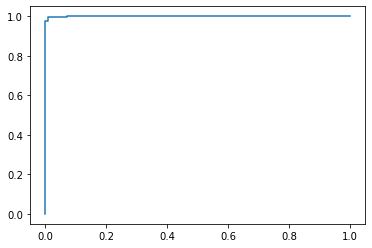

In [19]:

#	簡易的に，ROC曲線をかいてみる

import matplotlib.pyplot as plt
plt.plot(fpf, tpf)

In [20]:

#	ROC曲線下（きょくせんか）面積は，その観察者の判別性能を表します．
#	値が大きい（最大１．０）ほど，２群の分離がよいことを表します．

roc_auc_score(trainingGS, resubgender[:,1])


0.9994444584732709

/anaconda3/envs/dls/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


1.0


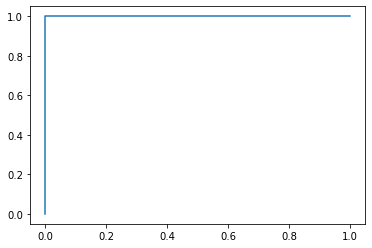

In [24]:


#画像データを読み込み
testdata = pd.read_csv("./testdata.csv")
testImgData = np.zeros((len(testdata["filenames"]), 128, 128, 1))

for i in range(0, len(testdata["filenames"])):
    fnametmp = './image/%s' %testdata["filenames"][i]
    testImgData[i] = np.array(img_to_array(load_img(fnametmp, grayscale=True, target_size=(128,128))))/255.0

#正解データを読み込み
testGSData = np.zeros((len(testdata["abnormal"]),  1), dtype='int')
for i in range(0, len(testdata["filenames"])):
   testGSData[i][0]=testdata["abnormal"][i]

#正解のラベル
testGS = testGSData.copy()
testGS = np.ravel(testGS)

#モデルに画像を代入
valigender = model.predict(testImgData)

#偽陽性率，真陽性率を計算
fpf, tpf, thresholds = metrics.roc_curve(testGS, valigender[:,1])

#ROC曲線を
plt.plot(fpf, tpf)

#曲線下面積を計算
print(roc_auc_score(testGS, valigender[:,1]))


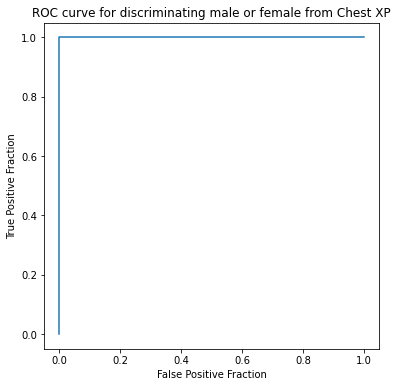

AUC = 1.0


In [25]:
#Step 15 ROC曲線

#正方形が気持ちいいからplt.figureで縦横の大きさを指定した
plt.figure(figsize=(6,6))
plt.plot(fpf, tpf)
plt.xlabel("False Positive Fraction")
plt.ylabel("True Positive Fraction")
plt.title("ROC curve for discriminating male or female from Chest XP")
plt.show()

#ROC曲線下面積
#少数点以下第３位で丸め（ほぼ四捨五入）
auc =roc_auc_score(testGS, valigender[:,1])
print('AUC =', round(auc, 3))

In [26]:
####ガタガタなのは，サンプル数が少ないから　かつ／もしくは　分布の形

len(testGS)

20